In [2]:
import torch
import torchvision

In [3]:
import pandas as pd

In [4]:
data = pd.read_csv('stories_ImagesTexts.csv')

In [6]:
data.head()

,story_id,texts,images
0,127,"['Нажмите «Изменить ПИН-код».', 'Введите новую...",['https://static2.tinkoff.ru/portfolio/stories...
1,254,"['Как\xa0пополнить карту «Стрелка»', 'Введите ...",['https://static2.tinkoff.ru/portfolio/stories...
2,865,"['Как воспользоваться', 'Войдите в личный каби...",['https://static2.tinkoff.ru/portfolio/stories...
3,1491,"['Музыка', 'Если вы вдруг заскучаете, попробуй...",['https://static2.tinkoff.ru/portfolio/stories...
4,598,"['Прыжки на батуте', 'Если бег, бассейн и трен...",['https://static2.tinkoff.ru/portfolio/stories...


In [125]:
import requests
from matplotlib import pyplot as plt
import ast
import urllib
import numpy as np
from PIL import Image
from io import BytesIO
from torchvision import transforms
import os
%matplotlib inline

In [126]:
def load_pic(array, i, data):
    array = ast.literal_eval(array)
    for n, url in enumerate(array):
        response = urllib.request.urlopen(url)
        im = Image.open(BytesIO(response.read()))
        directory = '/pictures/' + str(data['story_id'][i]) + '/'
        if not os.path.exists(directory):
            os.makedirs(directory)
        im.save(directory + '{}.png'.format(n))

In [149]:
from torchvision.models import resnet18

In [150]:
net = resnet18(pretrained=True, progress=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\i1999/.cache\torch\checkpoints\resnet18-5c106cde.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:08<00:00, 5.60MB/s]


In [179]:
for param in net.parameters():
    param.requires_grad = False

In [189]:
def image_converter(net, x):
        net.eval()
        x = net.conv1(x)
        x = net.bn1(x)
        x = net.relu(x)
        x = net.maxpool(x)

        x = net.layer1(x)
        x = net.layer2(x)
        x = net.layer3(x)
        x = net.layer4(x)

        x = net.avgpool(x)
        x = torch.flatten(x, 1)
        return x.numpy()

In [154]:
from torchvision.datasets import ImageFolder

In [155]:
im_transform = transforms.Compose([transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
folder = ImageFolder('C:/dev/hackathon-tinkoff/pictures/', transform=im_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


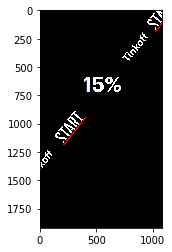

In [172]:
plt.imshow(folder[3][0].permute(1, 2, 0))

In [175]:
classes = folder._find_classes('C:/dev/hackathon-tinkoff/pictures/')

In [186]:
from collections import defaultdict

In [187]:
dic = defaultdict(list)

In [222]:
for i in folder:
    if classes[0][i[1]] not in dic:
        dic[classes[0][i[1]]].append(image_converter(net, i[0].unsqueeze(0)))

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [223]:
len(dic)

958

In [224]:
for key in dic.keys():
    dic[key] = np.mean(dic[key], axis=0)

In [242]:
dic['501'] = np.mean(list(dic.values()), axis=0)

In [244]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.bn0 = torch.nn.BatchNorm1d(512)
        self.fc1 = torch.nn.Linear(512, 256)
        self.ac1 = torch.nn.ELU()
        self.bn1 = torch.nn.BatchNorm1d(256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.ac2 = torch.nn.ELU()
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.fc3 = torch.nn.Linear(128, 64)
        self.ac3 = torch.nn.ELU()
        self.bn3 = torch.nn.BatchNorm1d(64)
        self.fc4 = torch.nn.Linear(64, 128)
        self.ac4 = torch.nn.ELU()
        self.bn4 = torch.nn.BatchNorm1d(128)
        self.fc5 = torch.nn.Linear(128, 256)
        self.ac5 = torch.nn.ELU()
        self.bn5 = torch.nn.BatchNorm1d(256)
        self.fc6 = torch.nn.Linear(256, 512)
        
    def forward(x):
        x = self.bn0(x)
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.bn2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        x = self.bn3(x)
        x = self.fc4(x)
        x = self.ac4(x)
        x = self.bn4(x)
        x = self.fc5(x)
        x = self.ac5(x)
        x = self.bn5(x)
        x = self.ac6(x)
        return x
    
    def encode(x):
        x = self.bn0(x)
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.bn2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        x = self.bn3(x)
        return x
    
    def decode(x):
        x = self.fc4(x)
        x = self.ac4(x)
        x = self.bn4(x)
        x = self.fc5(x)
        x = self.ac5(x)
        x = self.bn5(x)
        x = self.ac6(x)
        return x

In [245]:
X = list(dic.values())

In [246]:
X_test = X[:700]

In [247]:
len(X_test)

700

In [249]:
X_train = X[700:]

In [250]:
len(X_train)

259

In [251]:
import pickle

In [252]:
with open('dict.pickle', 'wb') as handle:
    pickle.dump(dic, handle)